In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-5, 5))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(data_df[['rt', 'choice']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(7289, 5) (7289, 5)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 229s 229s/step - loss: 60279.4219
Epoch 2/3500
1/1 [==============================] - 0s 63ms/step - loss: 59892.9922
Epoch 3/3500
1/1 [==============================] - 0s 46ms/step - loss: 59621.7891
Epoch 4/3500
1/1 [==============================] - 0s 50ms/step - loss: 59398.0391
Epoch 5/3500
1/1 [==============================] - 0s 45ms/step - loss: 59201.2188
Epoch 6/3500
1/1 [==============================] - 0s 44ms/step - loss: 59022.0000
Epoch 7/3500
1/1 [==============================] - 0s 44ms/step - loss: 58855.1797
Epoch 8/3500
1/1 [==============================] - 0s 44ms/step - loss: 58697.4766
Epoch 9/3500
1/1 [==============================] - 0s 44ms/step - loss: 58546.6484
Epoch 10/3500
1/1 [==============================] - 0s 45ms/step - loss: 58401.1094
Epoch 11/3500
1/1 [==============================] - 0s 45ms/step - loss: 58259.7266
Epoch 12/3500
1/1 [==============================] - 0s 46ms/step - loss

1/1 [==============================] - 0s 69ms/step - loss: 50563.8125
Epoch 98/3500
1/1 [==============================] - 0s 66ms/step - loss: 50511.8125
Epoch 99/3500
1/1 [==============================] - 0s 67ms/step - loss: 50460.2109
Epoch 100/3500
1/1 [==============================] - 0s 68ms/step - loss: 50408.9922
Epoch 101/3500
1/1 [==============================] - 0s 68ms/step - loss: 50358.1250
Epoch 102/3500
1/1 [==============================] - 0s 70ms/step - loss: 50307.5938
Epoch 103/3500
1/1 [==============================] - 0s 68ms/step - loss: 50257.3789
Epoch 104/3500
1/1 [==============================] - 0s 66ms/step - loss: 50207.4688
Epoch 105/3500
1/1 [==============================] - 0s 67ms/step - loss: 50157.8438
Epoch 106/3500
1/1 [==============================] - 0s 69ms/step - loss: 50108.5156
Epoch 107/3500
1/1 [==============================] - 0s 67ms/step - loss: 50059.4688
Epoch 108/3500
1/1 [==============================] - 0s 68ms/step - lo

1/1 [==============================] - 0s 68ms/step - loss: 46914.3828
Epoch 193/3500
1/1 [==============================] - 0s 67ms/step - loss: 46886.3867
Epoch 194/3500
1/1 [==============================] - 0s 67ms/step - loss: 46858.5352
Epoch 195/3500
1/1 [==============================] - 0s 70ms/step - loss: 46830.8125
Epoch 196/3500
1/1 [==============================] - 0s 68ms/step - loss: 46803.2344
Epoch 197/3500
1/1 [==============================] - 0s 68ms/step - loss: 46775.7930
Epoch 198/3500
1/1 [==============================] - 0s 66ms/step - loss: 46748.4766
Epoch 199/3500
1/1 [==============================] - 0s 67ms/step - loss: 46721.2969
Epoch 200/3500
1/1 [==============================] - 0s 66ms/step - loss: 46694.2422
Epoch 201/3500
1/1 [==============================] - 0s 67ms/step - loss: 46667.3281
Epoch 202/3500
1/1 [==============================] - 0s 70ms/step - loss: 46640.5273
Epoch 203/3500
1/1 [==============================] - 0s 69ms/step - 

1/1 [==============================] - 0s 71ms/step - loss: 44702.4062
Epoch 288/3500
1/1 [==============================] - 0s 73ms/step - loss: 44682.5273
Epoch 289/3500
1/1 [==============================] - 0s 73ms/step - loss: 44662.7031
Epoch 290/3500
1/1 [==============================] - 0s 72ms/step - loss: 44642.9258
Epoch 291/3500
1/1 [==============================] - 0s 70ms/step - loss: 44623.1992
Epoch 292/3500
1/1 [==============================] - 0s 73ms/step - loss: 44603.5195
Epoch 293/3500
1/1 [==============================] - 0s 72ms/step - loss: 44583.8789
Epoch 294/3500
1/1 [==============================] - 0s 71ms/step - loss: 44564.2969
Epoch 295/3500
1/1 [==============================] - 0s 72ms/step - loss: 44544.7578
Epoch 296/3500
1/1 [==============================] - 0s 69ms/step - loss: 44525.2578
Epoch 297/3500
1/1 [==============================] - 0s 73ms/step - loss: 44505.8203
Epoch 298/3500
1/1 [==============================] - 0s 74ms/step - 

1/1 [==============================] - 0s 67ms/step - loss: 42988.9609
Epoch 383/3500
1/1 [==============================] - 0s 68ms/step - loss: 42972.4219
Epoch 384/3500
1/1 [==============================] - 0s 67ms/step - loss: 42955.9102
Epoch 385/3500
1/1 [==============================] - 0s 67ms/step - loss: 42939.4141
Epoch 386/3500
1/1 [==============================] - 0s 66ms/step - loss: 42922.9531
Epoch 387/3500
1/1 [==============================] - 0s 67ms/step - loss: 42906.5156
Epoch 388/3500
1/1 [==============================] - 0s 67ms/step - loss: 42890.0977
Epoch 389/3500
1/1 [==============================] - 0s 67ms/step - loss: 42873.7070
Epoch 390/3500
1/1 [==============================] - 0s 66ms/step - loss: 42857.3438
Epoch 391/3500
1/1 [==============================] - 0s 66ms/step - loss: 42841.0039
Epoch 392/3500
1/1 [==============================] - 0s 68ms/step - loss: 42824.6797
Epoch 393/3500
1/1 [==============================] - 0s 67ms/step - 

1/1 [==============================] - 0s 67ms/step - loss: 41517.6562
Epoch 478/3500
1/1 [==============================] - 0s 66ms/step - loss: 41503.1289
Epoch 479/3500
1/1 [==============================] - 0s 67ms/step - loss: 41488.6328
Epoch 480/3500
1/1 [==============================] - 0s 67ms/step - loss: 41474.1484
Epoch 481/3500
1/1 [==============================] - 0s 67ms/step - loss: 41459.6875
Epoch 482/3500
1/1 [==============================] - 0s 67ms/step - loss: 41445.2422
Epoch 483/3500
1/1 [==============================] - 0s 66ms/step - loss: 41430.8125
Epoch 484/3500
1/1 [==============================] - 0s 67ms/step - loss: 41416.4062
Epoch 485/3500
1/1 [==============================] - 0s 69ms/step - loss: 41402.0156
Epoch 486/3500
1/1 [==============================] - 0s 66ms/step - loss: 41387.6445
Epoch 487/3500
1/1 [==============================] - 0s 67ms/step - loss: 41373.2852
Epoch 488/3500
1/1 [==============================] - 0s 67ms/step - 

1/1 [==============================] - 0s 69ms/step - loss: 40113.0078
Epoch 573/3500
1/1 [==============================] - 0s 69ms/step - loss: 40096.1914
Epoch 574/3500
1/1 [==============================] - 0s 69ms/step - loss: 40079.4023
Epoch 575/3500
1/1 [==============================] - 0s 68ms/step - loss: 40062.6328
Epoch 576/3500
1/1 [==============================] - 0s 69ms/step - loss: 40045.8984
Epoch 577/3500
1/1 [==============================] - 0s 68ms/step - loss: 40029.1875
Epoch 578/3500
1/1 [==============================] - 0s 67ms/step - loss: 40012.5078
Epoch 579/3500
1/1 [==============================] - 0s 67ms/step - loss: 39995.8477
Epoch 580/3500
1/1 [==============================] - 0s 67ms/step - loss: 39979.2266
Epoch 581/3500
1/1 [==============================] - 0s 66ms/step - loss: 39962.6289
Epoch 582/3500
1/1 [==============================] - 0s 68ms/step - loss: 39946.0625
Epoch 583/3500
1/1 [==============================] - 0s 69ms/step - 

1/1 [==============================] - 0s 69ms/step - loss: 38616.7148
Epoch 668/3500
1/1 [==============================] - 0s 66ms/step - loss: 38602.3711
Epoch 669/3500
1/1 [==============================] - 0s 67ms/step - loss: 38588.0820
Epoch 670/3500
1/1 [==============================] - 0s 67ms/step - loss: 38573.8008
Epoch 671/3500
1/1 [==============================] - 0s 68ms/step - loss: 38559.5898
Epoch 672/3500
1/1 [==============================] - 0s 67ms/step - loss: 38545.3906
Epoch 673/3500
1/1 [==============================] - 0s 66ms/step - loss: 38531.2500
Epoch 674/3500
1/1 [==============================] - 0s 67ms/step - loss: 38517.1211
Epoch 675/3500
1/1 [==============================] - 0s 67ms/step - loss: 38503.0547
Epoch 676/3500
1/1 [==============================] - 0s 66ms/step - loss: 38489.0039
Epoch 677/3500
1/1 [==============================] - 0s 68ms/step - loss: 38475.0078
Epoch 678/3500
1/1 [==============================] - 0s 68ms/step - 

1/1 [==============================] - 0s 67ms/step - loss: 37401.2031
Epoch 763/3500
1/1 [==============================] - 0s 68ms/step - loss: 37389.7695
Epoch 764/3500
1/1 [==============================] - 0s 68ms/step - loss: 37378.3008
Epoch 765/3500
1/1 [==============================] - 0s 68ms/step - loss: 37366.9141
Epoch 766/3500
1/1 [==============================] - 0s 67ms/step - loss: 37355.4844
Epoch 767/3500
1/1 [==============================] - 0s 67ms/step - loss: 37344.1328
Epoch 768/3500
1/1 [==============================] - 0s 67ms/step - loss: 37332.7461
Epoch 769/3500
1/1 [==============================] - 0s 68ms/step - loss: 37321.4375
Epoch 770/3500
1/1 [==============================] - 0s 66ms/step - loss: 37310.0977
Epoch 771/3500
1/1 [==============================] - 0s 67ms/step - loss: 37298.8281
Epoch 772/3500
1/1 [==============================] - 0s 67ms/step - loss: 37287.5234
Epoch 773/3500
1/1 [==============================] - 0s 68ms/step - 

1/1 [==============================] - 0s 68ms/step - loss: 36371.2266
Epoch 858/3500
1/1 [==============================] - 0s 68ms/step - loss: 36360.7539
Epoch 859/3500
1/1 [==============================] - 0s 67ms/step - loss: 36350.3281
Epoch 860/3500
1/1 [==============================] - 0s 68ms/step - loss: 36339.8516
Epoch 861/3500
1/1 [==============================] - 0s 68ms/step - loss: 36329.4375
Epoch 862/3500
1/1 [==============================] - 0s 67ms/step - loss: 36318.9648
Epoch 863/3500
1/1 [==============================] - 0s 66ms/step - loss: 36308.5469
Epoch 864/3500
1/1 [==============================] - 0s 67ms/step - loss: 36298.0781
Epoch 865/3500
1/1 [==============================] - 0s 67ms/step - loss: 36287.6680
Epoch 866/3500
1/1 [==============================] - 0s 67ms/step - loss: 36277.1953
Epoch 867/3500
1/1 [==============================] - 0s 67ms/step - loss: 36266.7891
Epoch 868/3500
1/1 [==============================] - 0s 67ms/step - 

1/1 [==============================] - 0s 68ms/step - loss: 35363.4297
Epoch 953/3500
1/1 [==============================] - 0s 67ms/step - loss: 35351.7852
Epoch 954/3500
1/1 [==============================] - 0s 67ms/step - loss: 35339.9844
Epoch 955/3500
1/1 [==============================] - 0s 66ms/step - loss: 35328.1484
Epoch 956/3500
1/1 [==============================] - 0s 67ms/step - loss: 35316.1562
Epoch 957/3500
1/1 [==============================] - 0s 66ms/step - loss: 35304.1016
Epoch 958/3500
1/1 [==============================] - 0s 67ms/step - loss: 35291.8633
Epoch 959/3500
1/1 [==============================] - 0s 68ms/step - loss: 35279.5547
Epoch 960/3500
1/1 [==============================] - 0s 74ms/step - loss: 35267.0352
Epoch 961/3500
1/1 [==============================] - 0s 68ms/step - loss: 35254.4219
Epoch 962/3500
1/1 [==============================] - 0s 68ms/step - loss: 35241.5625
Epoch 963/3500
1/1 [==============================] - 0s 67ms/step - 

1/1 [==============================] - 0s 70ms/step - loss: 33498.5703
Epoch 1047/3500
1/1 [==============================] - 0s 75ms/step - loss: 33481.7188
Epoch 1048/3500
1/1 [==============================] - 0s 75ms/step - loss: 33464.7578
Epoch 1049/3500
1/1 [==============================] - 0s 71ms/step - loss: 33447.8242
Epoch 1050/3500
1/1 [==============================] - 0s 69ms/step - loss: 33430.7891
Epoch 1051/3500
1/1 [==============================] - 0s 72ms/step - loss: 33413.7695
Epoch 1052/3500
1/1 [==============================] - 0s 75ms/step - loss: 33396.6406
Epoch 1053/3500
1/1 [==============================] - 0s 71ms/step - loss: 33379.5312
Epoch 1054/3500
1/1 [==============================] - 0s 68ms/step - loss: 33362.3008
Epoch 1055/3500
1/1 [==============================] - 0s 68ms/step - loss: 33345.0703
Epoch 1056/3500
1/1 [==============================] - 0s 70ms/step - loss: 33327.6719
Epoch 1057/3500
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 67ms/step - loss: 31725.2520
Epoch 1141/3500
1/1 [==============================] - 0s 67ms/step - loss: 31711.0430
Epoch 1142/3500
1/1 [==============================] - 0s 67ms/step - loss: 31696.7500
Epoch 1143/3500
1/1 [==============================] - 0s 66ms/step - loss: 31682.6562
Epoch 1144/3500
1/1 [==============================] - 0s 66ms/step - loss: 31668.4805
Epoch 1145/3500
1/1 [==============================] - 0s 67ms/step - loss: 31654.5039
Epoch 1146/3500
1/1 [==============================] - 0s 67ms/step - loss: 31640.4453
Epoch 1147/3500
1/1 [==============================] - 0s 67ms/step - loss: 31626.5840
Epoch 1148/3500
1/1 [==============================] - 0s 67ms/step - loss: 31612.6367
Epoch 1149/3500
1/1 [==============================] - 0s 68ms/step - loss: 31598.8965
Epoch 1150/3500
1/1 [==============================] - 0s 66ms/step - loss: 31585.0664
Epoch 1151/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 71ms/step - loss: 30638.8203
Epoch 1235/3500
1/1 [==============================] - 0s 67ms/step - loss: 30629.9062
Epoch 1236/3500
1/1 [==============================] - 0s 66ms/step - loss: 30620.9180
Epoch 1237/3500
1/1 [==============================] - 0s 67ms/step - loss: 30612.0898
Epoch 1238/3500
1/1 [==============================] - 0s 66ms/step - loss: 30603.1914
Epoch 1239/3500
1/1 [==============================] - 0s 67ms/step - loss: 30594.4453
Epoch 1240/3500
1/1 [==============================] - 0s 67ms/step - loss: 30585.6289
Epoch 1241/3500
1/1 [==============================] - 0s 67ms/step - loss: 30576.9727
Epoch 1242/3500
1/1 [==============================] - 0s 67ms/step - loss: 30568.2383
Epoch 1243/3500
1/1 [==============================] - 0s 67ms/step - loss: 30559.6582
Epoch 1244/3500
1/1 [==============================] - 0s 68ms/step - loss: 30551.0059
Epoch 1245/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 29935.7402
Epoch 1329/3500
1/1 [==============================] - 0s 67ms/step - loss: 29929.4297
Epoch 1330/3500
1/1 [==============================] - 0s 67ms/step - loss: 29923.0449
Epoch 1331/3500
1/1 [==============================] - 0s 67ms/step - loss: 29916.7734
Epoch 1332/3500
1/1 [==============================] - 0s 66ms/step - loss: 29910.4258
Epoch 1333/3500
1/1 [==============================] - 0s 67ms/step - loss: 29904.1836
Epoch 1334/3500
1/1 [==============================] - 0s 67ms/step - loss: 29897.8750
Epoch 1335/3500
1/1 [==============================] - 0s 67ms/step - loss: 29891.6719
Epoch 1336/3500
1/1 [==============================] - 0s 67ms/step - loss: 29885.3906
Epoch 1337/3500
1/1 [==============================] - 0s 67ms/step - loss: 29879.2266
Epoch 1338/3500
1/1 [==============================] - 0s 67ms/step - loss: 29872.9844
Epoch 1339/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 29410.0098
Epoch 1423/3500
1/1 [==============================] - 0s 67ms/step - loss: 29405.1992
Epoch 1424/3500
1/1 [==============================] - 0s 66ms/step - loss: 29400.2676
Epoch 1425/3500
1/1 [==============================] - 0s 66ms/step - loss: 29395.4727
Epoch 1426/3500
1/1 [==============================] - 0s 71ms/step - loss: 29390.5723
Epoch 1427/3500
1/1 [==============================] - 0s 67ms/step - loss: 29385.8047
Epoch 1428/3500
1/1 [==============================] - 0s 67ms/step - loss: 29380.9297
Epoch 1429/3500
1/1 [==============================] - 0s 66ms/step - loss: 29376.2051
Epoch 1430/3500
1/1 [==============================] - 0s 69ms/step - loss: 29371.3477
Epoch 1431/3500
1/1 [==============================] - 0s 68ms/step - loss: 29366.6426
Epoch 1432/3500
1/1 [==============================] - 0s 68ms/step - loss: 29361.8184
Epoch 1433/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 70ms/step - loss: 29004.0020
Epoch 1517/3500
1/1 [==============================] - 0s 70ms/step - loss: 29000.3281
Epoch 1518/3500
1/1 [==============================] - 0s 70ms/step - loss: 28996.4336
Epoch 1519/3500
1/1 [==============================] - 0s 70ms/step - loss: 28992.7012
Epoch 1520/3500
1/1 [==============================] - 0s 68ms/step - loss: 28988.8320
Epoch 1521/3500
1/1 [==============================] - 0s 68ms/step - loss: 28985.1270
Epoch 1522/3500
1/1 [==============================] - 0s 67ms/step - loss: 28981.2812
Epoch 1523/3500
1/1 [==============================] - 0s 66ms/step - loss: 28977.6016
Epoch 1524/3500
1/1 [==============================] - 0s 68ms/step - loss: 28973.8008
Epoch 1525/3500
1/1 [==============================] - 0s 66ms/step - loss: 28970.1602
Epoch 1526/3500
1/1 [==============================] - 0s 68ms/step - loss: 28966.3281
Epoch 1527/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 28682.3672
Epoch 1611/3500
1/1 [==============================] - 0s 67ms/step - loss: 28679.3945
Epoch 1612/3500
1/1 [==============================] - 0s 67ms/step - loss: 28676.1875
Epoch 1613/3500
1/1 [==============================] - 0s 68ms/step - loss: 28673.3359
Epoch 1614/3500
1/1 [==============================] - 0s 70ms/step - loss: 28670.2793
Epoch 1615/3500
1/1 [==============================] - 0s 73ms/step - loss: 28667.3281
Epoch 1616/3500
1/1 [==============================] - 0s 69ms/step - loss: 28664.2363
Epoch 1617/3500
1/1 [==============================] - 0s 68ms/step - loss: 28661.1777
Epoch 1618/3500
1/1 [==============================] - 0s 68ms/step - loss: 28658.0742
Epoch 1619/3500
1/1 [==============================] - 0s 67ms/step - loss: 28655.0117
Epoch 1620/3500
1/1 [==============================] - 0s 67ms/step - loss: 28651.9648
Epoch 1621/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 28420.6777
Epoch 1705/3500
1/1 [==============================] - 0s 66ms/step - loss: 28418.2754
Epoch 1706/3500
1/1 [==============================] - 0s 68ms/step - loss: 28415.4219
Epoch 1707/3500
1/1 [==============================] - 0s 67ms/step - loss: 28413.2285
Epoch 1708/3500
1/1 [==============================] - 0s 66ms/step - loss: 28410.5195
Epoch 1709/3500
1/1 [==============================] - 0s 67ms/step - loss: 28408.2188
Epoch 1710/3500
1/1 [==============================] - 0s 67ms/step - loss: 28405.5234
Epoch 1711/3500
1/1 [==============================] - 0s 67ms/step - loss: 28403.2383
Epoch 1712/3500
1/1 [==============================] - 0s 67ms/step - loss: 28400.7617
Epoch 1713/3500
1/1 [==============================] - 0s 67ms/step - loss: 28398.3945
Epoch 1714/3500
1/1 [==============================] - 0s 66ms/step - loss: 28395.6758
Epoch 1715/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 70ms/step - loss: 28199.7812
Epoch 1799/3500
1/1 [==============================] - 0s 71ms/step - loss: 28197.6289
Epoch 1800/3500
1/1 [==============================] - 0s 71ms/step - loss: 28195.2188
Epoch 1801/3500
1/1 [==============================] - 0s 70ms/step - loss: 28193.4023
Epoch 1802/3500
1/1 [==============================] - 0s 71ms/step - loss: 28190.9121
Epoch 1803/3500
1/1 [==============================] - 0s 69ms/step - loss: 28188.9531
Epoch 1804/3500
1/1 [==============================] - 0s 68ms/step - loss: 28186.4434
Epoch 1805/3500
1/1 [==============================] - 0s 69ms/step - loss: 28184.4121
Epoch 1806/3500
1/1 [==============================] - 0s 68ms/step - loss: 28181.9766
Epoch 1807/3500
1/1 [==============================] - 0s 69ms/step - loss: 28180.1426
Epoch 1808/3500
1/1 [==============================] - 0s 70ms/step - loss: 28177.8086
Epoch 1809/3500
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 67ms/step - loss: 28002.4375
Epoch 1893/3500
1/1 [==============================] - 0s 67ms/step - loss: 28000.2773
Epoch 1894/3500
1/1 [==============================] - 0s 68ms/step - loss: 27998.1230
Epoch 1895/3500
1/1 [==============================] - 0s 67ms/step - loss: 27996.1387
Epoch 1896/3500
1/1 [==============================] - 0s 68ms/step - loss: 27993.9297
Epoch 1897/3500
1/1 [==============================] - 0s 68ms/step - loss: 27992.3203
Epoch 1898/3500
1/1 [==============================] - 0s 68ms/step - loss: 27989.9941
Epoch 1899/3500
1/1 [==============================] - 0s 68ms/step - loss: 27988.3633
Epoch 1900/3500
1/1 [==============================] - 0s 67ms/step - loss: 27985.8730
Epoch 1901/3500
1/1 [==============================] - 0s 67ms/step - loss: 27984.1836
Epoch 1902/3500
1/1 [==============================] - 0s 67ms/step - loss: 27981.9141
Epoch 1903/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 27818.9902
Epoch 1987/3500
1/1 [==============================] - 0s 68ms/step - loss: 27817.1484
Epoch 1988/3500
1/1 [==============================] - 0s 68ms/step - loss: 27814.9980
Epoch 1989/3500
1/1 [==============================] - 0s 68ms/step - loss: 27813.2656
Epoch 1990/3500
1/1 [==============================] - 0s 68ms/step - loss: 27811.1406
Epoch 1991/3500
1/1 [==============================] - 0s 68ms/step - loss: 27809.7305
Epoch 1992/3500
1/1 [==============================] - 0s 68ms/step - loss: 27807.5820
Epoch 1993/3500
1/1 [==============================] - 0s 68ms/step - loss: 27806.5430
Epoch 1994/3500
1/1 [==============================] - 0s 67ms/step - loss: 27804.4609
Epoch 1995/3500
1/1 [==============================] - 0s 67ms/step - loss: 27802.5996
Epoch 1996/3500
1/1 [==============================] - 0s 69ms/step - loss: 27800.5039
Epoch 1997/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27660.1250
Epoch 2081/3500
1/1 [==============================] - 0s 67ms/step - loss: 27658.8281
Epoch 2082/3500
1/1 [==============================] - 0s 67ms/step - loss: 27657.1074
Epoch 2083/3500
1/1 [==============================] - 0s 67ms/step - loss: 27655.8418
Epoch 2084/3500
1/1 [==============================] - 0s 68ms/step - loss: 27654.0801
Epoch 2085/3500
1/1 [==============================] - 0s 68ms/step - loss: 27652.9297
Epoch 2086/3500
1/1 [==============================] - 0s 67ms/step - loss: 27651.0996
Epoch 2087/3500
1/1 [==============================] - 0s 67ms/step - loss: 27649.9238
Epoch 2088/3500
1/1 [==============================] - 0s 67ms/step - loss: 27648.1719
Epoch 2089/3500
1/1 [==============================] - 0s 68ms/step - loss: 27646.9648
Epoch 2090/3500
1/1 [==============================] - 0s 67ms/step - loss: 27645.1543
Epoch 2091/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 27534.5762
Epoch 2175/3500
1/1 [==============================] - 0s 67ms/step - loss: 27533.8848
Epoch 2176/3500
1/1 [==============================] - 0s 67ms/step - loss: 27532.4609
Epoch 2177/3500
1/1 [==============================] - 0s 66ms/step - loss: 27531.8672
Epoch 2178/3500
1/1 [==============================] - 0s 66ms/step - loss: 27530.7773
Epoch 2179/3500
1/1 [==============================] - 0s 66ms/step - loss: 27529.9648
Epoch 2180/3500
1/1 [==============================] - 0s 66ms/step - loss: 27528.4980
Epoch 2181/3500
1/1 [==============================] - 0s 68ms/step - loss: 27527.3809
Epoch 2182/3500
1/1 [==============================] - 0s 68ms/step - loss: 27525.9062
Epoch 2183/3500
1/1 [==============================] - 0s 67ms/step - loss: 27524.7422
Epoch 2184/3500
1/1 [==============================] - 0s 67ms/step - loss: 27523.1387
Epoch 2185/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 78ms/step - loss: 27435.8398
Epoch 2269/3500
1/1 [==============================] - 0s 74ms/step - loss: 27435.2461
Epoch 2270/3500
1/1 [==============================] - 0s 73ms/step - loss: 27433.8359
Epoch 2271/3500
1/1 [==============================] - 0s 70ms/step - loss: 27433.0898
Epoch 2272/3500
1/1 [==============================] - 0s 72ms/step - loss: 27431.8105
Epoch 2273/3500
1/1 [==============================] - 0s 74ms/step - loss: 27431.1055
Epoch 2274/3500
1/1 [==============================] - 0s 73ms/step - loss: 27429.9180
Epoch 2275/3500
1/1 [==============================] - 0s 73ms/step - loss: 27429.4766
Epoch 2276/3500
1/1 [==============================] - 0s 69ms/step - loss: 27428.2734
Epoch 2277/3500
1/1 [==============================] - 0s 67ms/step - loss: 27427.5391
Epoch 2278/3500
1/1 [==============================] - 0s 69ms/step - loss: 27426.2148
Epoch 2279/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27353.4609
Epoch 2363/3500
1/1 [==============================] - 0s 67ms/step - loss: 27353.1211
Epoch 2364/3500
1/1 [==============================] - 0s 67ms/step - loss: 27351.9805
Epoch 2365/3500
1/1 [==============================] - 0s 69ms/step - loss: 27351.7656
Epoch 2366/3500
1/1 [==============================] - 0s 69ms/step - loss: 27350.5488
Epoch 2367/3500
1/1 [==============================] - 0s 68ms/step - loss: 27350.1523
Epoch 2368/3500
1/1 [==============================] - 0s 68ms/step - loss: 27349.0117
Epoch 2369/3500
1/1 [==============================] - 0s 68ms/step - loss: 27348.3926
Epoch 2370/3500
1/1 [==============================] - 0s 66ms/step - loss: 27347.9375
Epoch 2371/3500
1/1 [==============================] - 0s 67ms/step - loss: 27347.1465
Epoch 2372/3500
1/1 [==============================] - 0s 67ms/step - loss: 27346.1562
Epoch 2373/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 69ms/step - loss: 27284.8945
Epoch 2457/3500
1/1 [==============================] - 0s 70ms/step - loss: 27284.2109
Epoch 2458/3500
1/1 [==============================] - 0s 69ms/step - loss: 27283.3281
Epoch 2459/3500
1/1 [==============================] - 0s 68ms/step - loss: 27283.3203
Epoch 2460/3500
1/1 [==============================] - 0s 69ms/step - loss: 27282.4805
Epoch 2461/3500
1/1 [==============================] - 0s 70ms/step - loss: 27282.1934
Epoch 2462/3500
1/1 [==============================] - 0s 69ms/step - loss: 27280.7090
Epoch 2463/3500
1/1 [==============================] - 0s 69ms/step - loss: 27280.1953
Epoch 2464/3500
1/1 [==============================] - 0s 68ms/step - loss: 27279.1035
Epoch 2465/3500
1/1 [==============================] - 0s 67ms/step - loss: 27278.8945
Epoch 2466/3500
1/1 [==============================] - 0s 67ms/step - loss: 27278.1230
Epoch 2467/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27226.1016
Epoch 2551/3500
1/1 [==============================] - 0s 65ms/step - loss: 27225.7969
Epoch 2552/3500
1/1 [==============================] - 0s 69ms/step - loss: 27225.3516
Epoch 2553/3500
1/1 [==============================] - 0s 69ms/step - loss: 27225.3164
Epoch 2554/3500
1/1 [==============================] - 0s 69ms/step - loss: 27224.8633
Epoch 2555/3500
1/1 [==============================] - 0s 72ms/step - loss: 27224.3828
Epoch 2556/3500
1/1 [==============================] - 0s 73ms/step - loss: 27223.6680
Epoch 2557/3500
1/1 [==============================] - 0s 69ms/step - loss: 27222.6660
Epoch 2558/3500
1/1 [==============================] - 0s 70ms/step - loss: 27222.0195
Epoch 2559/3500
1/1 [==============================] - 0s 75ms/step - loss: 27221.4297
Epoch 2560/3500
1/1 [==============================] - 0s 70ms/step - loss: 27220.7422
Epoch 2561/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27176.8848
Epoch 2645/3500
1/1 [==============================] - 0s 67ms/step - loss: 27176.7461
Epoch 2646/3500
1/1 [==============================] - 0s 68ms/step - loss: 27176.0664
Epoch 2647/3500
1/1 [==============================] - 0s 66ms/step - loss: 27175.9102
Epoch 2648/3500
1/1 [==============================] - 0s 67ms/step - loss: 27175.4570
Epoch 2649/3500
1/1 [==============================] - 0s 67ms/step - loss: 27175.1016
Epoch 2650/3500
1/1 [==============================] - 0s 68ms/step - loss: 27174.3086
Epoch 2651/3500
1/1 [==============================] - 0s 67ms/step - loss: 27173.8633
Epoch 2652/3500
1/1 [==============================] - 0s 67ms/step - loss: 27173.2109
Epoch 2653/3500
1/1 [==============================] - 0s 67ms/step - loss: 27172.8652
Epoch 2654/3500
1/1 [==============================] - 0s 66ms/step - loss: 27172.4043
Epoch 2655/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27134.9082
Epoch 2739/3500
1/1 [==============================] - 0s 68ms/step - loss: 27134.6875
Epoch 2740/3500
1/1 [==============================] - 0s 67ms/step - loss: 27134.2891
Epoch 2741/3500
1/1 [==============================] - 0s 73ms/step - loss: 27134.0039
Epoch 2742/3500
1/1 [==============================] - 0s 67ms/step - loss: 27133.7031
Epoch 2743/3500
1/1 [==============================] - 0s 73ms/step - loss: 27133.3320
Epoch 2744/3500
1/1 [==============================] - 0s 73ms/step - loss: 27132.8164
Epoch 2745/3500
1/1 [==============================] - 0s 67ms/step - loss: 27132.3477
Epoch 2746/3500
1/1 [==============================] - 0s 66ms/step - loss: 27132.1797
Epoch 2747/3500
1/1 [==============================] - 0s 67ms/step - loss: 27131.3281
Epoch 2748/3500
1/1 [==============================] - 0s 67ms/step - loss: 27131.0156
Epoch 2749/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27099.0996
Epoch 2833/3500
1/1 [==============================] - 0s 68ms/step - loss: 27099.1602
Epoch 2834/3500
1/1 [==============================] - 0s 68ms/step - loss: 27098.1152
Epoch 2835/3500
1/1 [==============================] - 0s 67ms/step - loss: 27098.2734
Epoch 2836/3500
1/1 [==============================] - 0s 66ms/step - loss: 27097.4414
Epoch 2837/3500
1/1 [==============================] - 0s 68ms/step - loss: 27097.5527
Epoch 2838/3500
1/1 [==============================] - 0s 67ms/step - loss: 27097.6582
Epoch 2839/3500
1/1 [==============================] - 0s 67ms/step - loss: 27097.7773
Epoch 2840/3500
1/1 [==============================] - 0s 66ms/step - loss: 27097.0137
Epoch 2841/3500
1/1 [==============================] - 0s 67ms/step - loss: 27096.4062
Epoch 2842/3500
1/1 [==============================] - 0s 68ms/step - loss: 27095.9609
Epoch 2843/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 67ms/step - loss: 27069.8398
Epoch 2927/3500
1/1 [==============================] - 0s 68ms/step - loss: 27069.8203
Epoch 2928/3500
1/1 [==============================] - 0s 68ms/step - loss: 27068.5020
Epoch 2929/3500
1/1 [==============================] - 0s 68ms/step - loss: 27067.6758
Epoch 2930/3500
1/1 [==============================] - 0s 69ms/step - loss: 27066.9824
Epoch 2931/3500
1/1 [==============================] - 0s 69ms/step - loss: 27067.0859
Epoch 2932/3500
1/1 [==============================] - 0s 70ms/step - loss: 27066.3984
Epoch 2933/3500
1/1 [==============================] - 0s 69ms/step - loss: 27066.2344
Epoch 2934/3500
1/1 [==============================] - 0s 68ms/step - loss: 27066.2773
Epoch 2935/3500
1/1 [==============================] - 0s 69ms/step - loss: 27066.2031
Epoch 2936/3500
1/1 [==============================] - 0s 69ms/step - loss: 27066.2793
Epoch 2937/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 71ms/step - loss: 27044.8008
Epoch 3021/3500
1/1 [==============================] - 0s 70ms/step - loss: 27043.2500
Epoch 3022/3500
1/1 [==============================] - 0s 75ms/step - loss: 27042.8242
Epoch 3023/3500
1/1 [==============================] - 0s 76ms/step - loss: 27042.1543
Epoch 3024/3500
1/1 [==============================] - 0s 70ms/step - loss: 27042.4492
Epoch 3025/3500
1/1 [==============================] - 0s 71ms/step - loss: 27041.8711
Epoch 3026/3500
1/1 [==============================] - 0s 74ms/step - loss: 27042.3086
Epoch 3027/3500
1/1 [==============================] - 0s 72ms/step - loss: 27042.5938
Epoch 3028/3500
1/1 [==============================] - 0s 68ms/step - loss: 27042.8457
Epoch 3029/3500
1/1 [==============================] - 0s 68ms/step - loss: 27042.3594
Epoch 3030/3500
1/1 [==============================] - 0s 69ms/step - loss: 27041.8145
Epoch 3031/3500
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 67ms/step - loss: 27022.0137
Epoch 3115/3500
1/1 [==============================] - 0s 66ms/step - loss: 27022.2070
Epoch 3116/3500
1/1 [==============================] - 0s 66ms/step - loss: 27021.8965
Epoch 3117/3500
1/1 [==============================] - 0s 67ms/step - loss: 27021.4863
Epoch 3118/3500
1/1 [==============================] - 0s 67ms/step - loss: 27021.4590
Epoch 3119/3500
1/1 [==============================] - 0s 66ms/step - loss: 27021.6484
Epoch 3120/3500
1/1 [==============================] - 0s 66ms/step - loss: 27021.6094
Epoch 3121/3500
1/1 [==============================] - 0s 67ms/step - loss: 27022.1113
Epoch 3122/3500
1/1 [==============================] - 0s 67ms/step - loss: 27023.3906
Epoch 3123/3500
1/1 [==============================] - 0s 68ms/step - loss: 27023.6406
Epoch 3124/3500
1/1 [==============================] - 0s 67ms/step - loss: 27022.7109
Epoch 3125/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 69ms/step - loss: 27006.2520
Epoch 3209/3500
1/1 [==============================] - 0s 70ms/step - loss: 27005.8164
Epoch 3210/3500
1/1 [==============================] - 0s 67ms/step - loss: 27005.0840
Epoch 3211/3500
1/1 [==============================] - 0s 68ms/step - loss: 27004.3477
Epoch 3212/3500
1/1 [==============================] - 0s 67ms/step - loss: 27004.3711
Epoch 3213/3500
1/1 [==============================] - 0s 68ms/step - loss: 27003.7754
Epoch 3214/3500
1/1 [==============================] - 0s 66ms/step - loss: 27003.5449
Epoch 3215/3500
1/1 [==============================] - 0s 67ms/step - loss: 27003.5625
Epoch 3216/3500
1/1 [==============================] - 0s 67ms/step - loss: 27002.7695
Epoch 3217/3500
1/1 [==============================] - 0s 67ms/step - loss: 27003.4219
Epoch 3218/3500
1/1 [==============================] - 0s 67ms/step - loss: 27003.9414
Epoch 3219/3500
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 68ms/step - loss: 26991.0605
Epoch 3303/3500
1/1 [==============================] - 0s 69ms/step - loss: 26990.8320
Epoch 3304/3500
1/1 [==============================] - 0s 68ms/step - loss: 26990.0391
Epoch 3305/3500
1/1 [==============================] - 0s 70ms/step - loss: 26989.5059
Epoch 3306/3500
1/1 [==============================] - 0s 72ms/step - loss: 26990.3691
Epoch 3307/3500
1/1 [==============================] - 0s 79ms/step - loss: 26990.1719
Epoch 3308/3500
1/1 [==============================] - 0s 75ms/step - loss: 26990.3301
Epoch 3309/3500
1/1 [==============================] - 0s 70ms/step - loss: 26990.6738
Epoch 3310/3500
1/1 [==============================] - 0s 70ms/step - loss: 26989.2188
Epoch 3311/3500
1/1 [==============================] - 0s 78ms/step - loss: 26989.7852
Epoch 3312/3500
1/1 [==============================] - 0s 73ms/step - loss: 26991.4688
Epoch 3313/3500
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 70ms/step - loss: 26978.6699
Epoch 3397/3500
1/1 [==============================] - 0s 73ms/step - loss: 26978.2461
Epoch 3398/3500
1/1 [==============================] - 0s 71ms/step - loss: 26979.3672
Epoch 3399/3500
1/1 [==============================] - 0s 74ms/step - loss: 26979.0625
Epoch 3400/3500
1/1 [==============================] - 0s 74ms/step - loss: 26980.7559
Epoch 3401/3500
1/1 [==============================] - 0s 76ms/step - loss: 26981.1953
Epoch 3402/3500
1/1 [==============================] - 0s 75ms/step - loss: 26992.0703
Epoch 3403/3500
1/1 [==============================] - 0s 73ms/step - loss: 27064.4004
Epoch 3404/3500
1/1 [==============================] - 0s 75ms/step - loss: 27003.4160
Epoch 3405/3500
1/1 [==============================] - 0s 72ms/step - loss: 26986.3867
Epoch 3406/3500
1/1 [==============================] - 0s 74ms/step - loss: 26978.5742
Epoch 3407/3500
1/1 [==============================] - 0s 7

1/1 [==============================] - 0s 70ms/step - loss: 26968.3379
Epoch 3491/3500
1/1 [==============================] - 0s 70ms/step - loss: 26970.8398
Epoch 3492/3500
1/1 [==============================] - 0s 70ms/step - loss: 26973.1328
Epoch 3493/3500
1/1 [==============================] - 0s 68ms/step - loss: 26975.6992
Epoch 3494/3500
1/1 [==============================] - 0s 69ms/step - loss: 26978.1504
Epoch 3495/3500
1/1 [==============================] - 0s 69ms/step - loss: 26974.8594
Epoch 3496/3500
1/1 [==============================] - 0s 69ms/step - loss: 26972.4922
Epoch 3497/3500
1/1 [==============================] - 0s 71ms/step - loss: 26968.3516
Epoch 3498/3500
1/1 [==============================] - 0s 68ms/step - loss: 26966.2773
Epoch 3499/3500
1/1 [==============================] - 0s 69ms/step - loss: 26964.6562
Epoch 3500/3500
1/1 [==============================] - 0s 69ms/step - loss: 26964.3691


In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

228/228 [==============================] - 0s 333us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

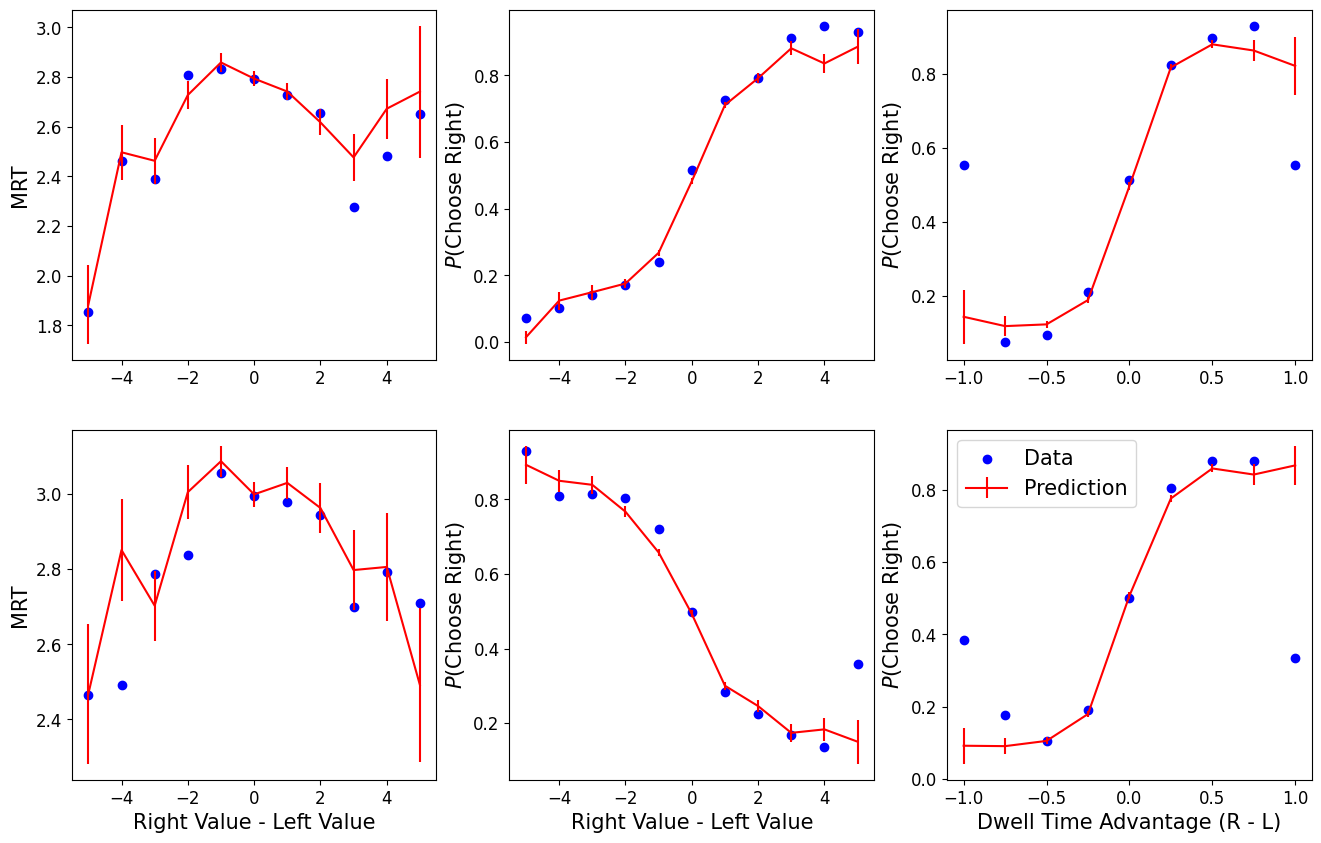

In [11]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_valuebased_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

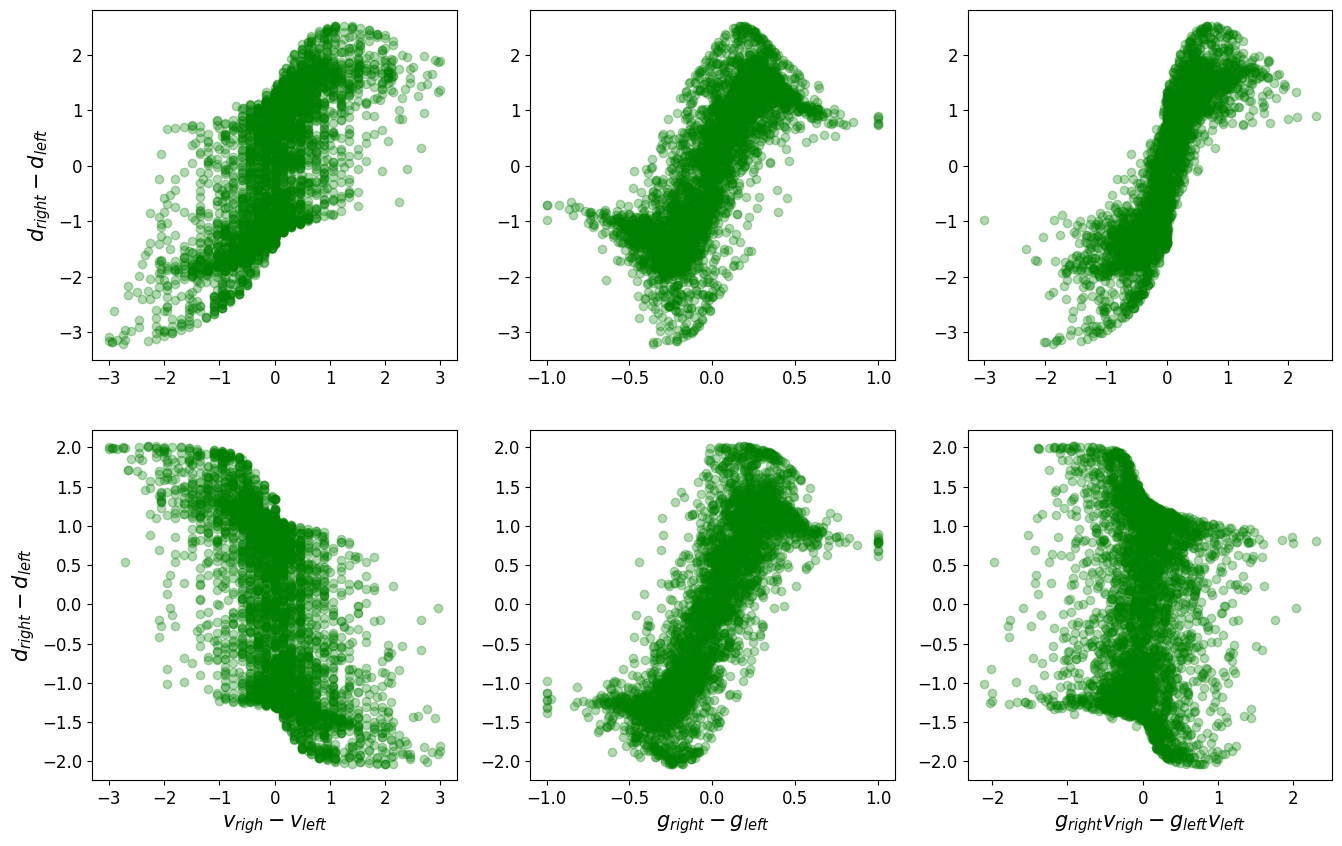

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');